In [109]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from thop import  clever_format

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
ESM_8M = "facebook/esm2_t6_8M_UR50D"
ESM_35M = "facebook/esm2_t12_35M_UR50D"
ESM_150M = "facebook/esm2_t30_150M_UR50D"
ESM_650M = "facebook/esm2_t33_650M_UR50D"
ESM_3B = "facebook/esm2_t36_3B_UR50D"
MODELS = [ESM_8M, ESM_35M, ESM_150M, ESM_650M, ESM_3B]

In [111]:
flops = []
memory = []
accuracy = []
seql = []
latency_df = []
gpu_util_df = []
for MODEL in MODELS: 
    mpath = MODEL.split('/')[1]
    print(MODEL)

    _flops = np.load(mpath + 'macs.npy')
    _memory = np.load(mpath + 'memory.npy')
    _accuracy = np.load(mpath + 'accuracy.npy')
    _seql = np.load(mpath + 'seql.npy')
    _latency_df = pd.read_csv("csv/" + mpath + '_latency', index_col=False )
    _gpu_util_df = pd.read_csv("csv/" + mpath + '_gpu_slen', index_col=False)

    # Preprocess flops and memory 
    t_flops = []
    t_memory = []

    for f in _flops:
        t_flops.append(f / 1000000000)

    for m in _memory:
        t_memory.append(m / 1000000000)

    _flops = np.array(t_flops)
    _memory = np.array(t_memory)

    flops.append(_flops)
    memory.append(_memory)
    accuracy.append(_accuracy)
    seql.append(_seql)
    latency_df.append(_latency_df)
    gpu_util_df.append(_gpu_util_df)

facebook/esm2_t6_8M_UR50D
facebook/esm2_t12_35M_UR50D
facebook/esm2_t30_150M_UR50D
facebook/esm2_t33_650M_UR50D
facebook/esm2_t36_3B_UR50D


# Plotters

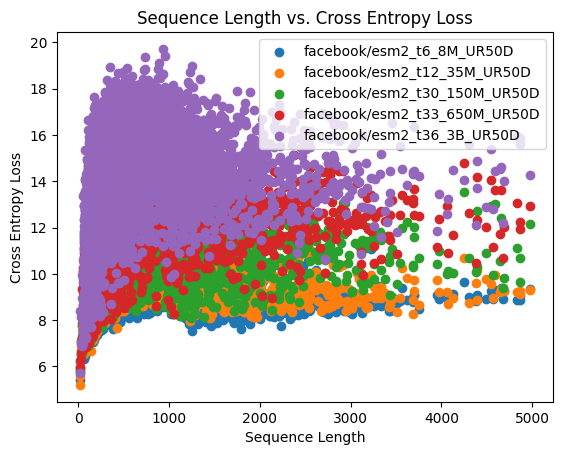

In [112]:
# Create a scatter plot
for i in range(0, len(MODELS)):
    plt.scatter(seql[i], accuracy[i], label=MODELS[i])

    # Label the axes
    plt.xlabel('Sequence Length')
    plt.ylabel('Cross Entropy Loss')

    # Add a title
    plt.title('Sequence Length vs. Cross Entropy Loss')

# Display the plot
plt.legend()
plt.show()

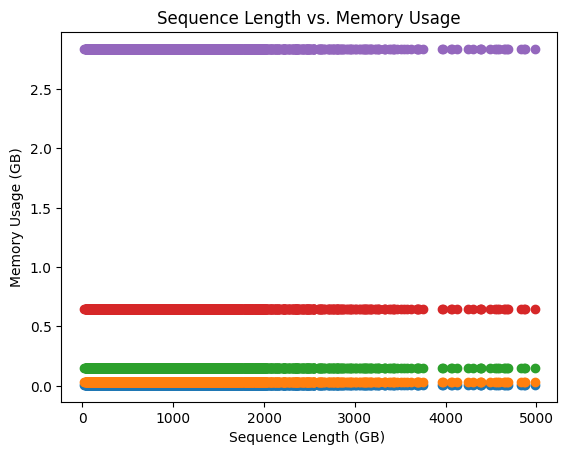

In [113]:
# Create a scatter plot
for i in range(0, len(MODELS)):
    plt.scatter(seql[i], memory[i])

    # Label the axes
    plt.xlabel('Sequence Length (GB) ')
    plt.ylabel('Memory Usage (GB)')

    # Add a title
    plt.title('Sequence Length vs. Memory Usage')

# Display the plot
plt.show()

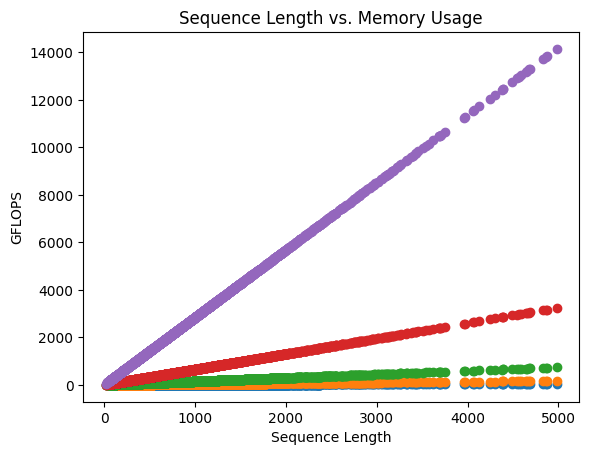

In [114]:
# Create a scatter plot
for i in range(0, len(MODELS)):
    plt.scatter(seql[i], flops[i])

    # Label the axes
    plt.xlabel('Sequence Length')
    plt.ylabel('GFLOPS')

    # Add a title
    plt.title('Sequence Length vs. Memory Usage')

# Display the plot
plt.show()

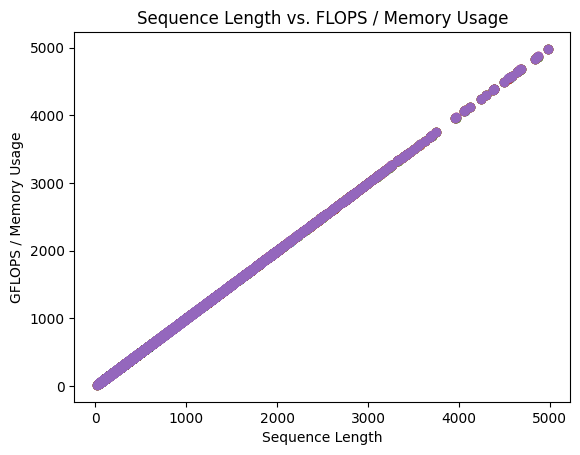

In [115]:
# Create a scatter plot
for i in range(0, len(MODELS)):
    plt.scatter(seql[i], flops[i] / memory[i])

    # Label the axes
    plt.xlabel('Sequence Length')
    plt.ylabel('GFLOPS / Memory Usage')

    # Add a title
    plt.title('Sequence Length vs. FLOPS / Memory Usage')

# Display the plot
plt.show()

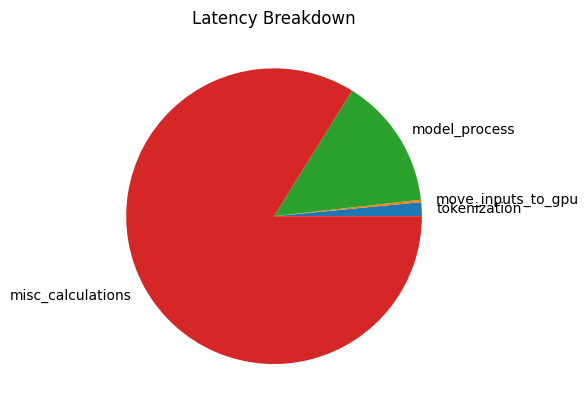

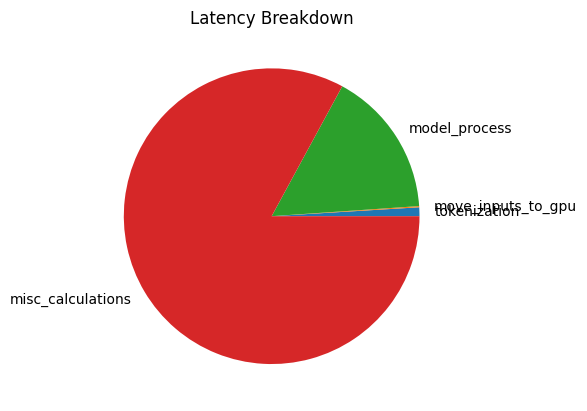

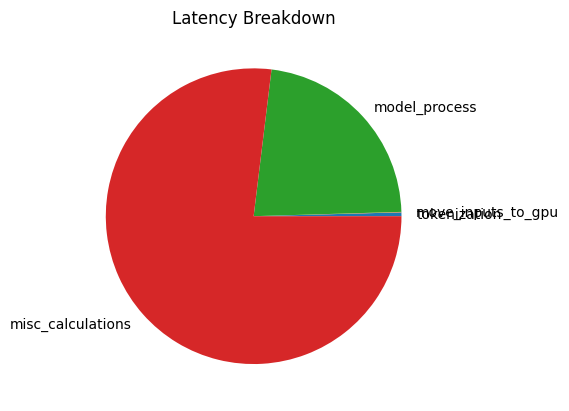

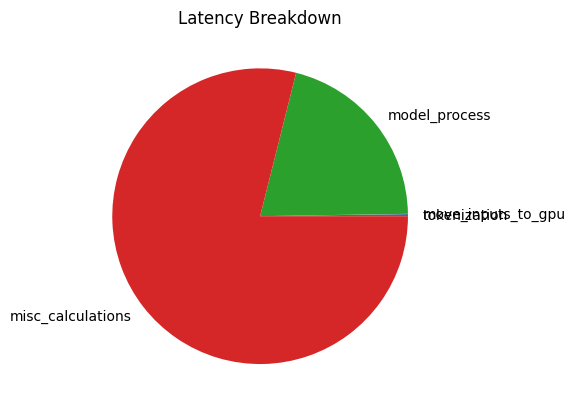

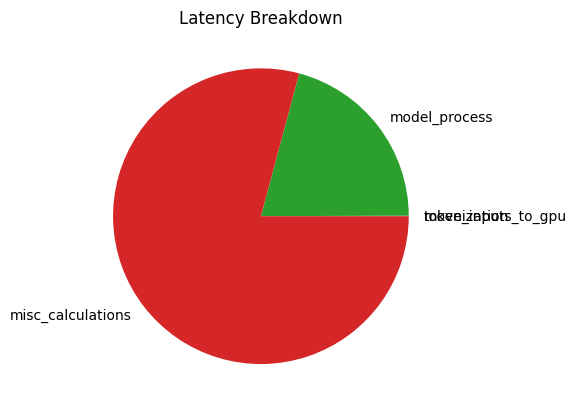

In [116]:
for i in range(0, len(MODELS)): 
    latency_sums = latency_df[i][['tokenization', 'move_inputs_to_gpu', 'model_process', 'cross_entropy_loss']].sum()
    pd.to_numeric(latency_sums,  errors='coerce')

    plt.title("Latency Breakdown")
    
    plt.pie(latency_sums.values.astype(float), labels = ['tokenization', 'move_inputs_to_gpu', 'model_process', 'misc_calculations'])
    plt.show()

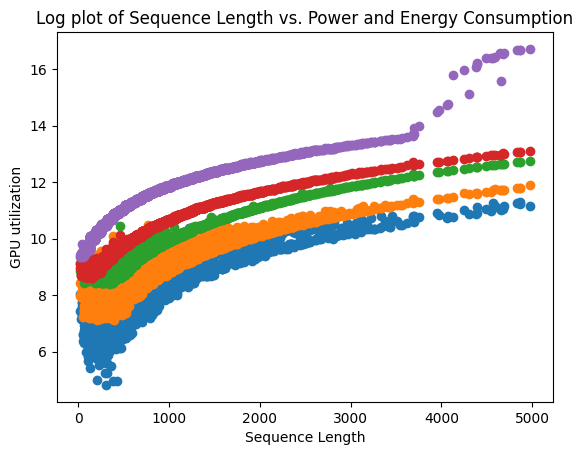

In [117]:
for i in range(0, len(MODELS)):
    duration = gpu_util_df[i]["duration"] * 100000

    # Create a scatter plot
    plt.scatter(seql[i], np.log(duration))

    # Label the axes
    plt.xlabel('Sequence Length')
    plt.ylabel('GPU utilization')

    # Add a title
    plt.title('Log plot of Sequence Length vs. Power and Energy Consumption')

# Display the plot
plt.show()